## Same as SkyBackground_FilterWidths, ...

but using filter transmission curves to calculate the sky background within some filter.

From Iridian:

>Also in the meeting we discussed "how narrow a filter we can offer and the angular sensitivity of this".  I have attached here some pdf slides on a "sub-nm " BPF demo that we have coated along with an excel file describing the effects of cone angle.  The narrowest filter that we can grow depends on the uniformity that can be achieved over the desired clear aperture.   One way to think about this is that there is an effective clear aperture outside of which the filter shifts by more than its bandwidth.  If the effective clear aperture < specified clear aperture, then the bandwidth is too narrow for the attainable uniformity.

>For a 0.04% total uniformity variation over a clear aperture of 150 mm, then the minimum bandwidth is CWL * uniformity.  For CWL=659 nm, the min bandwidth =  0.27 nm.   In practice, we'd probably want to limit a CWL shift due to uniformity to ½ the bandwidth (in order to still have the line of interest being transmitted) --> min FWHM = 0.54 nm for CWL = 659 nm.

>Adam has calculated the transmittance of three different FWHM filters (and the results are in the attached excel file) : <br>
a)	CWL=659 nm, FWHM = 3.1 nm,  Collimated, CHA = 1.5° and 11°  for AOI=0° and 10°  <br>
b)	CWL= 659 nm, FWHM = 0.8 nm, Collimated, CHA = 1.5° and 11°  for AOI=0° and 10°  <br>
c)	CWL= 659 nm, FWHM = 0.4 nm, Collimated, CHA = 1.5° and 11°  for AOI=0° and 10°  <br>

>As you can see, all of these calculations assume a flat profile with angle (worst case).  Adam did one calculation for a Gaussian profile - this is also in the excel file.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
from astropy.io import fits

In [45]:
plt.style.use('seaborn-dark-palette')
plt.style.use('ggplot')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
import matplotlib
matplotlib.rc('font', **font)

In [2]:
def loadBackgroundGemini(start,end,machine,plot=False,verbose=False):
    # Returns the total background flux in the wavlength interval supplied i.e. returns (flux)*(wavlength interval) 
    wavelength = []
    flux = []
    
    if machine=='chinook':
        geminiloc='/Users/lokhorst/Documents/Eagle/Gemini_skybackground.dat'
    elif machine=='coho':
        geminiloc='/Users/deblokhorst/Documents/Dragonfly/HalphaScripts/Gemini_skybackground.dat'
    
    with open(geminiloc,'r') as f:  #wavelength in nm, flux in phot/s/nm/arcsec^2/m^2
        for line in f:
            if line[0]!='#' and len(line)>5:
                tmp = line.split()
                wavelength.append(tmp[0])
                flux.append(tmp[1])
                
    wavelength = np.array(wavelength,'d')
    flux = np.array(flux,'d')
    
    start_ind = (np.abs(wavelength-start)).argmin()
    end_ind   = (np.abs(wavelength-end)).argmin()
        
    return wavelength[start_ind-1:end_ind+1],flux[start_ind-1:end_ind+1]

In [3]:
def loadBackgroundUVES(start,end,machine,plot=False,verbose=False):
    
    #start = start*10
    #end = end*10
    
    def getUVESBackground(filename):
        hdulist = fits.open(filename)
        flux = hdulist[0].data
    
        CRPIX1 = hdulist[0].header['CRPIX1']
        CRVAL1 = hdulist[0].header['CRVAL1']
        CDELT1 = hdulist[0].header['CDELT1']
        #print(CRPIX1,CRVAL1,CDELT1)
        hdulist.close()
        
        begin = CRVAL1 - CRPIX1*CDELT1   
        end = begin + len(flux)*CDELT1
        wavelength = np.arange(begin,end,CDELT1)
        #print(len(wavelength),len(flux))
        return wavelength,flux

    # Returns the total background flux in the wavlength interval supplied i.e. returns (flux)*(wavlength interval) 
    wavelength = []
    flux = []
    
    filename1 = "fluxed_sky_580U.fits"
    filename2 = "fluxed_sky_860L.fits"
    leakycolumns = [6340.5, 6407, 6475.5,6545, 6616, 6689,6763] # locations where should mask data
    # about 2 angstrom thick
    

    if machine=='coho':
        uvesloc = '/Users/deblokhorst/Dropbox/UVES_Sky_Background/UVES_sky_all/'
    elif machine =='chinook':
        uvesloc = '/Users/lokhorst/Dropbox/UVES_Sky_Background/UVES_sky_all/'
    else:
        print 'No machine specified!'
    
    wavelength_UVES1,flux_UVES1=getUVESBackground(uvesloc+filename1)
    wavelength_UVES2,flux_UVES2=getUVESBackground(uvesloc+filename2)

    if len(wavelength_UVES2)==(len(flux_UVES2)+1):
        if verbose:
            print('wavelength array is one element longer than the flux array.  Shortening the wavelength array.')
        wavelength_UVES2 = wavelength_UVES2[0:-1]
        
    wavelength = np.append(wavelength_UVES1[wavelength_UVES1<6700.],wavelength_UVES2[wavelength_UVES2>6700.])
    flux = np.append(flux_UVES1[wavelength_UVES1<6700.],flux_UVES2[wavelength_UVES2>6700.])
        
    wavelength = np.array(wavelength,'d')
    flux = np.array(flux,'d')
    
    # convert the units to nm and ph / s / nm / m**2 / arcsec**2
    wavelength = wavelength / 10.  
        # Angs --> nm
    flux = flux *10**-16 * ((wavelength*10**-9)/(const.h.to('erg s').value * const.c.to('m/s').value)) * 10. * (100/1)**2 
        # (erg --> photon) and (/ Ang --> / nm) and (/ cm**2 --> / m**2)
        
    start_ind = (np.abs(wavelength-start)).argmin()
    end_ind   = (np.abs(wavelength-end)).argmin()
    
    return wavelength[start_ind-1:end_ind+1],flux[start_ind-1:end_ind+1]

In [4]:
def getFluxFlatFilter(wavelength,flux,start,end):
    start_ind = 1
    end_ind = len(wavelength)-2
    # if spacings are not even, need to add element by element
    total=0
    for index in np.arange(start_ind,end_ind):
        total = total+(flux[index]*(wavelength[index+1]-wavelength[index]))
        
    # slight better
    fluxarray = flux[start_ind:end_ind]
    wavelenarray_left = wavelength[start_ind-1:end_ind-1]
    wavelenarray_cent = wavelength[start_ind:end_ind]
    wavelenarray_righ = wavelength[start_ind+1:end_ind+1]
    total3 = np.sum(fluxarray*(wavelenarray_righ-wavelenarray_left))/2.
           
    actualwavelenrange = np.mean([wavelenarray_cent[-1],wavelenarray_righ[-1]]) - \
                        np.mean([wavelenarray_left[0],wavelenarray_cent[0]])
    if verbose:
        print actualwavelenrange
        print end-start
        
    # scaling to match desired wavelength range, since resolution might not match up correctly
    total4 = total3 * (end-start)/actualwavelenrange
    
    if verbose:
        print 'COMPARE: %s and %s and %s'%(total,total3,total4)
        
    if plot==True:
        plt.plot(wavelength[start_ind-100:end_ind+100],flux[start_ind-100:end_ind+100])
        top = max(flux[start_ind-100:end_ind+100])
        plt.plot([start,start,end,end,start],[0,top,top,0,0])
        plt.show()
        
    return total4

In [318]:
filterdict = {}

def loadFilter(thisfilter,wavefront='Collimated'):
    """Load the Iridian Transmission curves from the data files for different bandpass filters (BPF).
    
       thisfilter:  specify which Iridian filter to load
                       Options: '6599_3nm_0deg','6599_3nm_10deg','6599_08nm_0deg','6599_08nm_10deg',
                                 '6599_08nm_10deg_Gaus','6599_04nm_0deg','6599_04nm_10deg'
       
       wavefront:  specify which wavefront type for the transmission curve
                       Options:  Collimated, ConeAngle22deg, ConeAngle3deg
    """
    # filter options
    filters = ['6599_3nm_0deg','6599_3nm_10deg','6599_08nm_0deg','6599_08nm_10deg',\
               '6599_08nm_10deg_Gaus','6599_04nm_0deg','6599_04nm_10deg']
    
    if thisfilter not in filters:
        print "WARNING: Filter specified not in list of options.  Using default filter."
        thisfilter = filters[0]
        
    # check if already loaded into dictionary first
    if thisfilter in filterdict:
        data = filterdict[thisfilter]
        return data['wavelen1'],data[wavefront]
    else:
        # load filter data from Iridian files
        data = np.genfromtxt('%s.dat'%thisfilter,  dtype='f', \
                             names=('wavelen1', 'Collimated', 'wavelen2', 'ConeAngle22deg', 'wavelen3','ConeAngle3deg'))
        # save into dictionary
        filterdict[thisfilter] = data

        return data['wavelen1'],data[wavefront]

def getHalphaSpec(AOI = 0):
    fname = 'halpha.dat'
    if AOI!=0:
        fname = 'halpha_shifted.dat'
    data = np.genfromtxt(fname,  dtype='f', names=('wavelength', 'flux'))
    return data['wavelength'],data['flux']
    
def getFlux(thisfilter,axis =None, sspectra = 'Gemini',shiftspectra=False,machine='coho',wavefront='Collimated',AOI=0):
    """Integrate over the filter and sky background spectrum.
    
        thisfilter:  specify which Iridian filter to load
        
        sspectra: specify which source spectra to use to integrate over and get total flux
                    Options: (sky background) Gemini, UVES (science) halpha
        
        machine: specify which machine you are running the code on (for locations of data)
                    Options: chinook, coho
    """
    # load data
    if sspectra == 'Gemini':
        dwavelength, dflux = loadBackgroundGemini(640.,680.,machine)
    elif sspectra =='UVES':
        dwavelength, dflux = loadBackgroundUVES(640.,680.,machine)
    elif sspectra == 'halpha':
        dwavelength, dflux = getHalphaSpec(AOI=0)
    elif type(sspectra) is tuple:
        print "WARNING: Taking input as a tuple containing (wavelength,flux) for source spectra."
        dwavelength, dflux = sspectra[0],sspectra[1]
    else:
        print "WARNING: Input source spectra not recognized. Please choose Gemini, UVES, or halpha. Returning None."
        return None
    
    if type(shiftspectra) is float:
        print 'Shifting spectra by %s...'%shiftspectra
        dwavelength = dwavelength-shiftspectra
    elif shiftspectra:
        print 'Shifting spectra by 2.42...'
        dwavelength = dwavelength-2.42

    # load transmission curve
    twavelength, tflux = loadFilter(thisfilter,wavefront=wavefront) #transmission curve of the filter
    
    # reinterpolate transmission onto the same wavelength def as the data
    itflux = np.interp(dwavelength, twavelength, tflux, left=0., right=0.)  
            ## left and right are the values for tflux for dwavelength outside range of twavelength
        
    if axis is not None:
        axis.plot(dwavelength, dflux)
        axis.plot(twavelength, tflux)
        
    # if the filter is null on that wavelength range flux is then 0
    ind = itflux > 0.  # makes a masked array where True if >0 and False if <=0
    
    if True in ind:
        # limit integrals to where necessary
        # ind = itflux > 0.
        total = np.trapz( itflux[ind] * dflux[ind], dwavelength[ind], axis=-1)
        if np.isinf(total).any():
            print("WARNING: inf value from integration.")
        return total
    else:
        return 0.


# to dos

- test loading the filter transmission curves
- plot the filter transmission curves with the sky spectra
- confirm that the units work out for the integral of the flux calculation


In [6]:
machine = 'coho'

In [201]:
twavelength, tflux = loadFilter('6599_3nm_0deg')
dwavelength, dflux = loadBackgroundGemini(640.,680.,machine)
dwavelength_u, dflux_u = loadBackgroundUVES(640.,680.,machine)
hwavelength, hflux = getHalphaSpec()
tswavelength, tsflux = loadFilter('6599_04nm_10deg')
hswavelength, hsflux = getHalphaSpec(AOI=10)
hswavelength2, hsflux2 = getHalphaSpec()
hswavelength2 = np.array(hswavelength2)-2.567

In [8]:
itflux = np.interp(dwavelength, twavelength, tflux, left=0., right=0.)

In [39]:
ind = itflux > 0.
total = np.trapz( itflux[ind] * dflux[ind], dwavelength[ind], axis=-1)
print total

print getFlux('6599_3nm_0deg',sspectra = 'Gemini',machine=machine)

1.5044920901
1.5044920901


In [168]:
colors = plt.get_cmap('viridis')(np.linspace(0.15,0.85,7))

(650, 670)

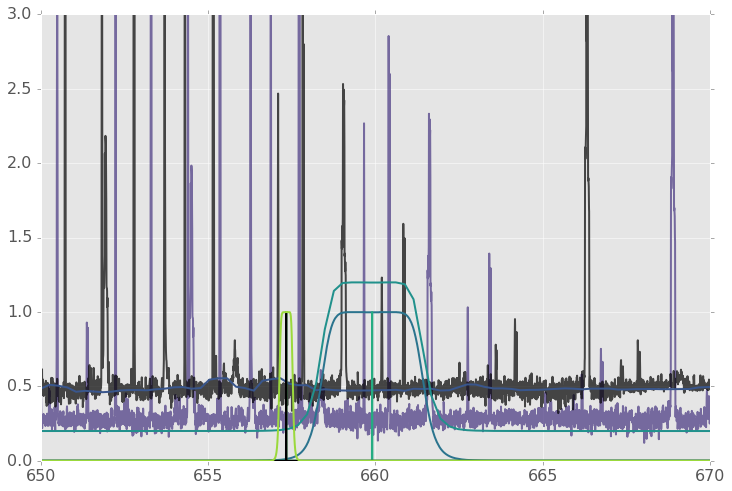

In [203]:
linewidth=2
plt.figure(figsize=(12,8))
plt.plot(dwavelength_u,dflux_u,color=colors[0],linewidth=linewidth,alpha=0.7)
plt.plot(np.array(dwavelength_u)-2.567,dflux_u+0.2,color='black',linewidth=linewidth,alpha=0.7)
plt.plot(dwavelength,dflux,color=colors[1],linewidth=linewidth)
plt.plot(twavelength,tflux,color=colors[2],linewidth=linewidth)
plt.plot(dwavelength,itflux+0.2,color=colors[3],linewidth=linewidth)
plt.plot(hwavelength,hflux,color=colors[4],linewidth=linewidth)
plt.plot(hswavelength,hsflux,color=colors[5],linewidth=linewidth)
plt.plot(hswavelength,hsflux,color='black',linewidth=linewidth)
plt.plot(tswavelength,tsflux,color=colors[6],linewidth=linewidth)
plt.ylim(0,3.)
plt.xlim(650,670)

In [63]:
filters = ['6599_3nm_0deg','6599_3nm_10deg','6599_08nm_0deg','6599_08nm_10deg',\
               '6599_08nm_10deg_Gaus','6599_04nm_0deg','6599_04nm_10deg']

wavefronts = ['Collimated', 'ConeAngle22deg', 'ConeAngle3deg']

filters_0deg = [filt for filt in filters if '_0deg' in filt]

for thisfilter in filters_0deg:
    for wavefront in wavefronts:
        print thisfilter, wavefront
        print getFlux(thisfilter,sspectra = 'Gemini',machine=machine,wavefront=wavefront)
        print getFlux(thisfilter,sspectra = 'UVES',machine=machine,wavefront=wavefront)
        print getFlux(thisfilter,sspectra = 'halpha',machine=machine,wavefront=wavefront)
        print ""

6599_3nm_0deg Collimated
1.5044920901
1.07540128962
0.00691363543228

6599_3nm_0deg ConeAngle22deg
1.53495463188
1.14780957936
0.00487695309857

6599_3nm_0deg ConeAngle3deg
1.50454319078
1.07354327903
0.0069141350541

6599_08nm_0deg Collimated
0.388730318499
0.276435783299
0.00692749023438

6599_08nm_0deg ConeAngle22deg
0.403821907516
0.288689265763
0.00244540395033

6599_08nm_0deg ConeAngle3deg
0.390369819167
0.274550390827
0.00692485090985

6599_04nm_0deg Collimated
0.224236874483
0.121580384824
0.00692749023438

6599_04nm_0deg ConeAngle22deg
0.203022180009
0.149025303119
0.00175265496819

6599_04nm_0deg ConeAngle3deg
0.199372801745
0.12780648657
0.00692458045341



Real effect for the cone angle filters is that the transmittance gets spread out over a wider range of wavelengths, and the peak transmittance drops dramatically.  This lowers the S/N.  To show that, need to also include the source signal.

Copying over some functions from **SignalToNoise_FilterWidthComparison** .

In [65]:
def Dragonfly(number_of_lenses = 48.,R_in = None,CMOS = False):
    area_lens = np.pi*(14.3/2)**2 * number_of_lenses * u.cm**2  # 48 * 14.3 cm diameter lenses
    pix_size = 2.8                                              # arcsec
    ang_size_pixel  = (pix_size * (1./206265.))**2 * u.rad**2   # rad^2, the pixel size of the CCD

    tau_l = 0.85  # transmittance of the Dragonfly lens
    tau_f = 1.    # transmittance of the Halpha filter -- assumed for now

    # The following are per pixel
    D = 0.04 *u.photon/u.second                             # dark current (electrons / s) -- PER PIXEL??
    
    if CMOS:
        print "VERBOSE: Using new CMOS cameras... (QE = 0.70, R = 2.)"
        QE = 0.70                # quantum efficiency of the CMOS detector
        R = 2.                   # read noise (electrons)
    else:
        print "VERBOSE: Using old cameras... (QE = 0.48, R = 10.)"
        QE = 0.48                # quantum efficiency of the CCDs
        R = 10.                  # read noise (electrons)

    R_squared = R**2 * u.photon
    
    if R_in is not None:
        R_squared = R_in**2 * u.photon
        print "VERBOSE: Modifying read noise with given input R = %s"%R_in
    
    return [area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, D, R_squared]

def calcTime2(SNR,SB_ph,B,explength=30.*(60.*u.second)):
    """ Returns the exposure time required to reach specified signal-to-noise ratio (SNR)
    
        SNR:  Desired signal-to-noise ratio, dimensionless. e.g. 1
    
        SB_ph:  The surface brightness of the signal, units of u.photon / (u.cm**2 * u.rad**2 * u.second)
        
        B:  The sky background within the filter, units of u.photon/u.second/u.arcsec**2/u.m**2
    """
    
    SNR = SNR*(u.photon)/np.sqrt(1*u.photon)
    I = SB_ph * QE * tau_l * tau_f * area_lens * ang_size_pixel * numpixel
    B_tot = B * QE * tau_l * tau_f * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)*numpixel 
    TOP = SNR**2 * (I + B_tot + D*numpixel*numlens + R_squared*numpixel*numlens/explength) 
    BOTTOM = I**2
    return TOP/BOTTOM

In [74]:
[area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, D, R_squared] = Dragonfly(CMOS=True)
numpixel = 100.0 * 100.0/(pix_size**2)   # 100-arcsec-a-side pixels
numlens=48.
SB_ph_three = 10**3. * u.photon / (u.cm**2 * u.rad**2 * u.second)
print SB_ph_three
print SB_ph_three.to(u.photon/u.second/u.arcsec**2/u.m**2)
calcTime2(1,SB_ph_three,0.5*u.photon/u.second/u.arcsec**2/u.m**2).to(u.hour).value

VERBOSE: Using new CMOS cameras... (QE = 0.70, R = 2.)
1000.0 ph / (cm2 rad2 s)
0.000235044305391 ph / (arcsec2 m2 s)


1.1661119109818507

## First Plot - at 0 deg incidence, compare effect of incoming beam shape...


...as a function of bandwidth.

In [147]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


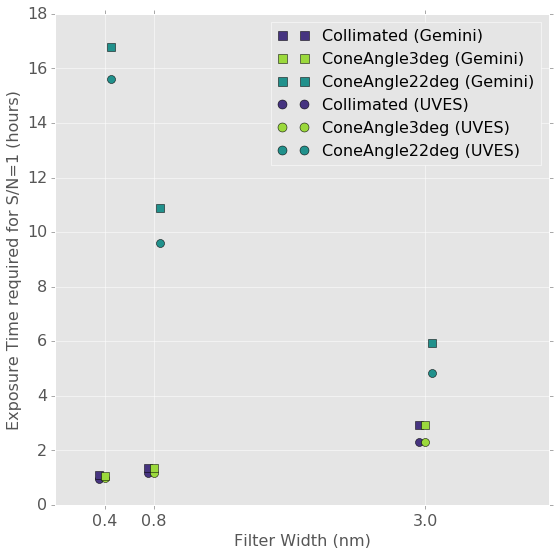

In [245]:
filters = ['6599_3nm_0deg','6599_3nm_10deg','6599_08nm_0deg','6599_08nm_10deg',\
               '6599_08nm_10deg_Gaus','6599_04nm_0deg','6599_04nm_10deg']

wavefronts = {'Collimated':colors[0], 'ConeAngle22deg':colors[3], 'ConeAngle3deg':colors[6]}

filters_0deg = [filt for filt in filters if '_0deg' in filt]

filtwidths = {'3nm':3.,'08nm':0.8,'04nm':0.4}

SNR = 1

verbose = False

plt.figure(figsize=(8,8))

shift = -0.05
for wavefront in ['Collimated','ConeAngle3deg','ConeAngle22deg']:
    reqtimes=[]
    reqtimes_g=[]
    xlocs=[]
    
    for thisfilter in filters_0deg:
        # get the filterwidth using a dictionary definition
        xloc = [filtwidths[key] for key in filtwidths if key in thisfilter]
        # load sky background in filter (gemini and uves for comparison)
        skysignal_g = getFlux(thisfilter,sspectra = 'Gemini',machine=machine,wavefront=wavefront)
        skysignal = getFlux(thisfilter,sspectra = 'UVES',machine=machine,wavefront=wavefront)
        # since 0deg aoi, load normal halpha in filter
        halphasignal = getFlux(thisfilter,sspectra = 'halpha',machine=machine,wavefront=wavefront)*0.03 # scale down a little
        # convert signals into correct units
        skysignal_g = skysignal_g*u.photon/u.second/u.arcsec**2/u.m**2
        skysignal = skysignal*u.photon/u.second/u.arcsec**2/u.m**2
        halphasignal = (halphasignal*u.photon/u.second/u.arcsec**2/u.m**2).to(u.photon/(u.cm**2*u.rad**2*u.second))
        # calculate required time to reach snr for both sky backgrounds, append to array
        reqtimes_g.append(calcTime2(1,halphasignal,skysignal_g).to(u.hour).value)
        reqtimes.append(calcTime2(1,halphasignal,skysignal).to(u.hour).value)
        xlocs.append(xloc[0])
        
        if verbose:
            print thisfilter, wavefront
            print skysignal
            print halphasignal
            print reqtime
            print ""
            
    plt.plot(np.array(xlocs)+shift,reqtimes,color=wavefronts[wavefront],marker='o',ms=8,linestyle = '')
    plt.plot(np.array(xlocs)+shift,reqtimes_g,color=wavefronts[wavefront],marker='s',ms=8,linestyle = '')
    shift = shift+0.05
    

6616

#p = np.poly1d(np.polyfit(xlocs, reqtimes, 2))
#x = np.arange(0,10,0.1)
#plt.plot(x,p(x))
        
for wavefront in ['Collimated','ConeAngle3deg','ConeAngle22deg']:
    plt.plot(-1,-1,color=wavefronts[wavefront],marker='s',markersize = 9,linestyle = '',label=wavefront+' (Gemini)')
for wavefront in ['Collimated','ConeAngle3deg','ConeAngle22deg']:
    plt.plot(-1,-1,color=wavefronts[wavefront],marker='o',markersize = 9,linestyle = '',label=wavefront+' (UVES)')
    
plt.legend()
plt.xlim(0,4)
plt.ylim(0,18)
plt.xticks([0.4,0.8,3.0])
plt.xlabel('Filter Width (nm)')
plt.ylabel('Exposure Time required for S/N=1 (hours)')
plt.tight_layout()
#plt.savefig('SkyBackground_IridianFilters.pdf')

## Second Plot - for collimated light, compare effect changing the angle of incidence


...as a function of bandwidth.


At AOI of 0deg, filter centered at: 659.9037nm

At AOI of 10deg, filter centered at: 657.3365nm

### Doesn't really make sense to compare cone angle wavefront, since if filter is behind optics, wouldn't be tilting.


In [192]:
659.9037-657.3365

2.567199999999957

Shifting spectra by 2.42...
Shifting spectra by 2.42...
Shifting spectra by 2.42...
Shifting spectra by 2.42...
Shifting spectra by 2.42...
Shifting spectra by 2.42...
Shifting spectra by 2.42...
Shifting spectra by 2.42...
Shifting spectra by 2.42...
Shifting spectra by 2.42...
Shifting spectra by 2.42...
Shifting spectra by 2.42...
Shifting spectra by 2.42...
Shifting spectra by 2.42...
Shifting spectra by 2.42...
Shifting spectra by 2.42...
Shifting spectra by 2.42...
Shifting spectra by 2.42...


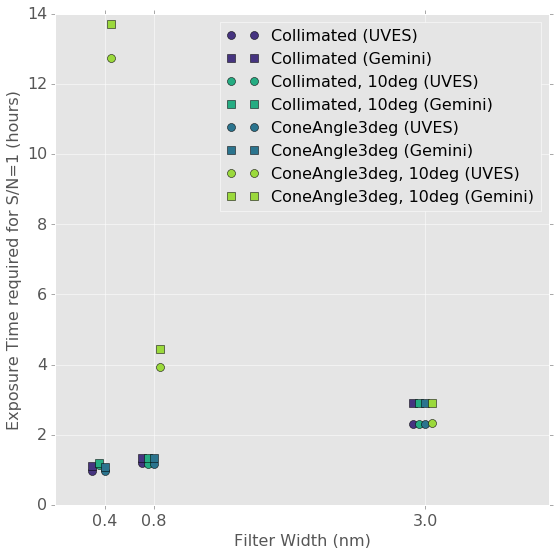

In [316]:
filters = ['6599_3nm_0deg','6599_3nm_10deg','6599_08nm_0deg','6599_08nm_10deg',\
               '6599_04nm_0deg','6599_04nm_10deg'] #'6599_08nm_10deg_Gaus',

filters_0deg = [filt for filt in filters if '_0deg' in filt]
filters_10deg = [filt for filt in filters if '_10deg' in filt]

wavefrontcolors = {'Collimated':colors[0], 'ConeAngle22deg':colors[1], 'ConeAngle3deg':colors[2],
                   'Collimated, 10deg':colors[4], 'ConeAngle22deg, 10deg':colors[4], 'ConeAngle3deg, 10deg':colors[6],}

filterwidths = {'3nm':3.,'08nm':0.8,'04nm':0.4}

verbose = False

def plotByFilterSet(filters_0deg,plotshift=0,shiftspectra=False,wavefront='Collimated',machine='coho',SNR=1,label=''):
    reqtimes_u=[]
    reqtimes_g=[]
    xlocs=[]

    for thisfilter in filters_0deg:
        # load sky background in filter (gemini and uves for comparison)
        skysignal_g = getFlux(thisfilter,sspectra = 'Gemini',machine=machine,wavefront=wavefront,shiftspectra=shiftspectra)
        skysignal_u = getFlux(thisfilter,sspectra = 'UVES',machine=machine,wavefront=wavefront,shiftspectra=shiftspectra)
        # since 0deg aoi, load normal halpha in filter
        halphasignal = getFlux(thisfilter,sspectra = 'halpha',machine=machine,wavefront=wavefront,shiftspectra=shiftspectra)*0.03 # scale down a little
        # convert signals into correct units
        skysignal_g = skysignal_g*u.photon/u.second/u.arcsec**2/u.m**2
        skysignal_u = skysignal_u*u.photon/u.second/u.arcsec**2/u.m**2
        halphasignal = (halphasignal*u.photon/u.second/u.arcsec**2/u.m**2).to(u.photon/(u.cm**2*u.rad**2*u.second))
        # calculate required time to reach snr for both sky backgrounds, append to array
        reqtimes_g.append(calcTime2(SNR,halphasignal,skysignal_g).to(u.hour).value)
        reqtimes_u.append(calcTime2(SNR,halphasignal,skysignal_u).to(u.hour).value)
        # get the filterwidth using a dictionary definition
        xloc = [filterwidths[key] for key in filterwidths if key in thisfilter]
        xlocs.append(xloc[0])
        
        if verbose:
            print thisfilter, wavefront
            print 'skysignal: %s, %s' %(skysignal_g, skysignal_u)
            print halphasignal
            print reqtimes_g, reqtimes_u
            print ""
    
    label = wavefront+label
    plt.plot(np.array(xlocs)+plotshift,reqtimes_u,color=wavefrontcolors[label],marker='o',ms=8,linestyle = '',
            label=label+' (UVES)',alpha=1)
    plt.plot(np.array(xlocs)+plotshift,reqtimes_g,color=wavefrontcolors[label],marker='s',ms=8,linestyle = '',
            label=label+' (Gemini)',alpha=1)
    
plt.figure(figsize=(8,8))

plotshift=-0.1    
for wavefront in ['Collimated','ConeAngle3deg']:#,'ConeAngle22deg']:    
    plotByFilterSet(filters_0deg,wavefront=wavefront,plotshift=plotshift)
    plotByFilterSet(filters_10deg,wavefront=wavefront,plotshift=plotshift+0.05,shiftspectra=True,label=', 10deg')
    plotshift = plotshift+0.1
            
plt.legend()
plt.xlim(0,4)
#plt.ylim(0,4)
plt.xticks([0.4,0.8,3.0])
plt.xlabel('Filter Width (nm)')
plt.ylabel('Exposure Time required for S/N=1 (hours)')
plt.tight_layout()

6599_3nm_0deg Collimated
skysignal: 1.5044920901 ph / (arcsec2 m2 s), 1.07540128962 ph / (arcsec2 m2 s)
882.425390496 ph / (cm2 rad2 s)
[2.9115856207576054] [2.30753699532965]

6599_08nm_0deg Collimated
skysignal: 0.388730318499 ph / (arcsec2 m2 s), 0.276435783299 ph / (arcsec2 m2 s)
884.193755239 ph / (cm2 rad2 s)
[2.9115856207576054, 1.3355247413997782] [2.30753699532965, 1.1780748288658374]

6599_04nm_0deg Collimated
skysignal: 0.224236874483 ph / (arcsec2 m2 s), 0.121580384824 ph / (arcsec2 m2 s)
884.193755239 ph / (cm2 rad2 s)
[2.9115856207576054, 1.3355247413997782, 1.104885927796541] [2.30753699532965, 1.1780748288658374, 0.9609496686623512]

Shifting spectra by 2.42...
Shifting spectra by 2.42...
Shifting spectra by 2.42...
6599_3nm_10deg Collimated
skysignal: 1.49255861379 ph / (arcsec2 m2 s), 1.0654467896 ph / (arcsec2 m2 s)
882.425390496 ph / (cm2 rad2 s)
[2.8947863793111797] [2.2935236395347594]

Shifting spectra by 2.42...
Shifting spectra by 2.42...
Shifting spectra by 2.

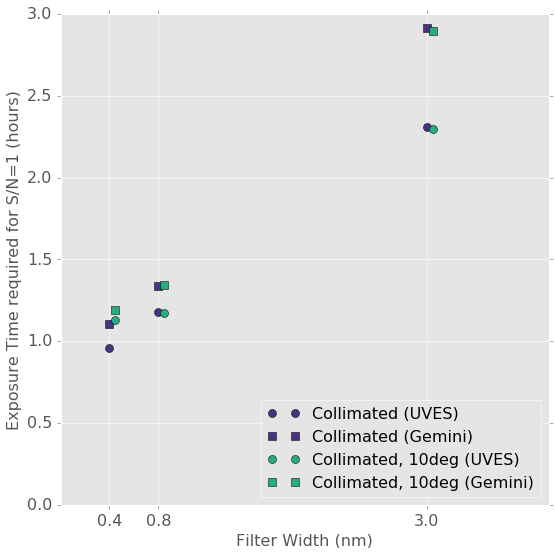

In [317]:
plt.figure(figsize=(8,8))
verbose=True
plotshift=0  
for wavefront in ['Collimated']:#,'ConeAngle3deg']:#,'ConeAngle22deg']:    
    plotByFilterSet(filters_0deg,wavefront=wavefront,plotshift=plotshift)
    plotByFilterSet(filters_10deg,wavefront=wavefront,plotshift=plotshift+0.05,shiftspectra=True,label=', 10deg')
    #plotshift = plotshift+0.1
            #2.567
plt.legend(loc=4)
plt.xlim(0,4)
plt.ylim(0,3)
plt.xticks([0.4,0.8,3.0])
plt.xlabel('Filter Width (nm)')
plt.ylabel('Exposure Time required for S/N=1 (hours)')
plt.tight_layout()
#plt.savefig('SkyBackground_IridianFilters.pdf')

probably the interpolation for the integration is different or something.  To figure it out, might have to start by plotting the filters and the shifted bandpasses and halpha and just look at it for a while.  (shifting the 

## Check what the shifts 

In [335]:
twavelength, tflux = loadFilter('6599_3nm_0deg')
tswavelength, tsflux = loadFilter('6599_3nm_10deg')

(650, 670)

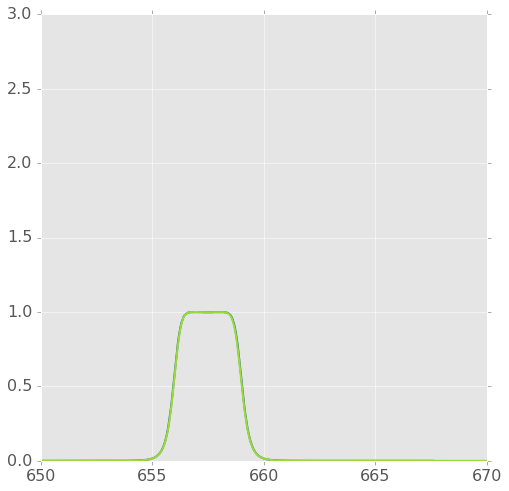

In [338]:
linewidth=2
plt.figure(figsize=(8,8))
plt.plot(twavelength-2.42,tflux,color=colors[2],linewidth=linewidth)
plt.plot(tswavelength,tsflux,color=colors[6],linewidth=linewidth)
plt.ylim(0,3.)
plt.xlim(650,670)

Shifting spectra by 2.42...
Shifting spectra by 2.42...
Shifting spectra by 2.42...
Shifting spectra by 2.5...
Shifting spectra by 2.5...
Shifting spectra by 2.5...
Shifting spectra by 2.42...
Shifting spectra by 2.42...
Shifting spectra by 2.42...


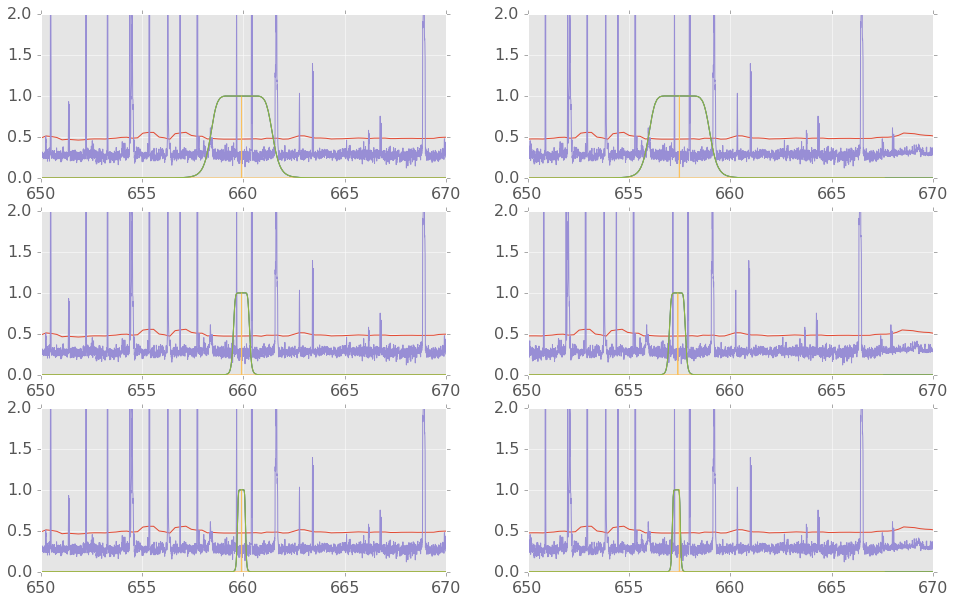

In [344]:
f,((ax1,ax2),(ax3,ax4),(ax5,ax6))=plt.subplots(3,2,figsize=(16,10))
shiftspectra=False
thisfilter='6599_3nm_0deg'
wavefront='Collimated'
skysignal_g = getFlux(thisfilter,sspectra = 'Gemini',machine=machine,wavefront=wavefront,shiftspectra=shiftspectra,
                     axis=ax1)
skysignal_u = getFlux(thisfilter,sspectra = 'UVES',machine=machine,wavefront=wavefront,shiftspectra=shiftspectra,
                     axis=ax1)
halphasignal = getFlux(thisfilter,sspectra = 'halpha',machine=machine,wavefront=wavefront,
                       shiftspectra=shiftspectra,axis=ax1)*0.03 # scale down a little

shiftspectra=True
thisfilter='6599_3nm_10deg'
wavefront='Collimated'
skysignal_g = getFlux(thisfilter,sspectra = 'Gemini',machine=machine,wavefront=wavefront,shiftspectra=shiftspectra,
                     axis=ax2)
skysignal_u = getFlux(thisfilter,sspectra = 'UVES',machine=machine,wavefront=wavefront,shiftspectra=shiftspectra,
                     axis=ax2)
halphasignal = getFlux(thisfilter,sspectra = 'halpha',machine=machine,wavefront=wavefront,
                       shiftspectra=shiftspectra,axis=ax2)*0.03 # scale down a little

shiftspectra=False
thisfilter='6599_08nm_0deg'
wavefront='Collimated'
skysignal_g = getFlux(thisfilter,sspectra = 'Gemini',machine=machine,wavefront=wavefront,shiftspectra=shiftspectra,
                     axis=ax3)
skysignal_u = getFlux(thisfilter,sspectra = 'UVES',machine=machine,wavefront=wavefront,shiftspectra=shiftspectra,
                     axis=ax3)
halphasignal = getFlux(thisfilter,sspectra = 'halpha',machine=machine,wavefront=wavefront,
                       shiftspectra=shiftspectra,axis=ax3)*0.03 # scale down a little

shiftspectra=2.5
thisfilter='6599_08nm_10deg'
wavefront='Collimated'
skysignal_g = getFlux(thisfilter,sspectra = 'Gemini',machine=machine,wavefront=wavefront,shiftspectra=shiftspectra,
                     axis=ax4)
skysignal_u = getFlux(thisfilter,sspectra = 'UVES',machine=machine,wavefront=wavefront,shiftspectra=shiftspectra,
                     axis=ax4)
halphasignal = getFlux(thisfilter,sspectra = 'halpha',machine=machine,wavefront=wavefront,
                       shiftspectra=shiftspectra,axis=ax4)*0.03 # scale down a little

shiftspectra=False
thisfilter='6599_04nm_0deg'
wavefront='Collimated'
skysignal_g = getFlux(thisfilter,sspectra = 'Gemini',machine=machine,wavefront=wavefront,shiftspectra=shiftspectra,
                     axis=ax5)
skysignal_u = getFlux(thisfilter,sspectra = 'UVES',machine=machine,wavefront=wavefront,shiftspectra=shiftspectra,
                     axis=ax5)
halphasignal = getFlux(thisfilter,sspectra = 'halpha',machine=machine,wavefront=wavefront,
                       shiftspectra=shiftspectra,axis=ax5)*0.03 # scale down a little

shiftspectra=True
thisfilter='6599_04nm_10deg'
wavefront='Collimated'
skysignal_g = getFlux(thisfilter,sspectra = 'Gemini',machine=machine,wavefront=wavefront,shiftspectra=shiftspectra,
                     axis=ax6)
skysignal_u = getFlux(thisfilter,sspectra = 'UVES',machine=machine,wavefront=wavefront,shiftspectra=shiftspectra,
                     axis=ax6)
halphasignal = getFlux(thisfilter,sspectra = 'halpha',machine=machine,wavefront=wavefront,
                       shiftspectra=shiftspectra,axis=ax6)*0.03 # scale down a little

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.set_ylim(0,2)
    ax.set_xlim(650,670)

